# Data Processes - Second Assignment 2024-2025

# COVID-19 project

## 1. Introduction

The COVID-19 pandemic has significantly affected various country’s health systems around the world more so in the year 2020 and in the subsequent years. In this project, we aim to analyze synthetic data from two hospitals, focusing on patients who visited the emergency departments of these hospitals. The characteristics of these patients entailed age, sex, nationality, body temperature, oxygen saturation and a number of other symptoms and comorbidities. Furthermore, the dataset includes the PCR tests results for the patients and shows if the patient was infected with the COVID-19 virus or no.

## 2. Goals and KPIs

The main goal of this project is to establish a business goal focused on enhancing early detection of COVID-19 cases and a data mining goal aimed at developing a predictive model, together enabling more accurate identification of at-risk patients early in their hospital visits.

**Business Goal:** Enhance early detection of COVID-19 cases using predictive modeling to optimize hospital resource allocation and reduce costs by 20% within the first three months. By accurately identifying at-risk patients early, the model enables more efficient management of medical resources, minimizes unnecessary testing, and streamlines patient care, ultimately leading to significant cost savings.

**Data Mining Goal:** Develop a predictive model that accurately predicts whether individuals are COVID-19 positive based on their symptoms and comorbidities.

**Key Performance Indicators (KPIs):**
1. Model performance:
  - Prediction Accuracy: 85% or higher for identifying COVID-19 positive cases based on symptoms and comorbidities
  - F1-Score: 0.8 or higher to balance precision and recall
2. Feature Insights:
  - Indentify top 5 most influential features (symptoms/comorbidities)
3. Impact on resource management:
  - By implementing a model that meets the specified performance metrics, we aim to streamline patient care and improve resource efficiency, contributing to a 20% reduction in operational costs.
  - **Cost Savings** = (Initial Costs−Reduced Costs) / Initial Costs × 100

## 3. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree, export_text
#from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
#To show an exact number of columns in a dataframe
pd.set_option('display.max_columns', 200)

#File loading function
def load_file():
    # Prompt the user to choose the environment: Google Colab or local
    choice = input("Do you want to load files in Google Colab or locally? (colab/local): ").strip().lower()

    if choice == 'colab':
        # If running in Google Colab
        print("Current working directory:", os.getcwd())
        from google.colab import files
        uploaded = files.upload()

        # Check if two files have been uploaded
        file_paths = list(uploaded.keys())
        if len(file_paths) < 2:
            print("Please upload two files.")
            return None, None

        # Load the datasets using the uploaded file paths
        hospital1 = pd.read_csv(file_paths[0], encoding='ISO8859_2', sep=';')
        hospital2 = pd.read_csv(file_paths[1], encoding='ISO8859_2', sep=';')

    elif choice == 'local':
        # If running locally, prompt for file paths
        file_path1 = input("Please enter the path for the first file (without quotes!): ")
        file_path2 = input("Please enter the path for the second file (without quotes!): ")

        try:
            # Load the datasets using the provided local paths
            hospital1 = pd.read_csv(file_path1, encoding='ISO8859_2', sep=';')
            hospital2 = pd.read_csv(file_path2, encoding='ISO8859_2', sep=';')
        except FileNotFoundError:
            print("File not found. Please check the path.")
            return None, None

    else:
        print("Invalid choice. Please select 'colab' or 'local'.")
        return None, None

    return hospital1, hospital2

# Example usage:
hospital1, hospital2 = load_file()

## 4. Exoloratory Data Analysis (EDA)

In [3]:
# 1. Compare data sets' columns
print("\n--- Compare data sets ---\n")
print("Common columns:")
common_columns = set(hospital1.columns) & set(hospital2.columns)
print(common_columns)

print("\Differing columns:")
diff_columns_1 = set(hospital1.columns) - set(hospital2.columns)
diff_columns_2 = set(hospital2.columns) - set(hospital1.columns)
print("Only in hospital1:", diff_columns_1)
print("Only in hospital2:", diff_columns_2)


--- Compare data sets ---

Common columns:
{'age', 'chronic_neurological_disorder', 'chronic_pulmonary_disease', 'skin_rash', 'history_of_fever', 'loss_of_smell', 'other_symptoms', 'other_risks', 'runny_nose', 'wheezing', 'smoking', 'loss_of_taste', 'diabetes_mellitus_type_1', 'liver_disease', 'conjunctivitis', 'lower_chest_wall_indrawing', 'dementia', 'vomiting_nausea', 'fever_temperature', 'obesity', 'sore_throat', 'date_of_first_symptoms', 'hypertension', 'headache', 'chest_pain', 'diarrhoea', 'AIDS_HIV', 'asthma', 'abdominal_pain', 'bleeding', 'fatigue_malaise', 'chronic_cardiac_disease', 'rheumatologic_disorder', 'oxygen_saturation', 'shortness_of_breath', 'altered_consciousness_confusion', 'asplenia', 'tuberculosis', 'joint_pain', 'PCR_result', 'cough', 'inability_to_walk', 'lymphadenopathy', 'diabetes_mellitus_type_2', 'malignant_neoplasm', 'chronic_hematologic_disease', 'anorexia', 'muscle_aches', 'chronic_kidney_disease'}
\Differing columns:
Only in hospital1: {'patient ID', 

NOTE: h1 = hospital1 and h2 = hospital2

All the columns are the same in the two datasets, except for (below):
- patient ID (h1) is the same as patient_id (h2)
- patient ID.1 (h1) should be the admission_id (h2)
- gender K=female E=male (h1) is column sex (h2)
- BASVURUTARIHI (h1) is in Turkish this is admission_date (h2)
- nationality (h1) is country_of_residence (h2)

In [4]:
# 2. Function for basic information, empty values, trends over time, correlation heatmap on numerical values

def perform_eda(df, hospital_name):
    print(f"\n--- {hospital_name} data set analysis ---\n")

    #----------------------Step 1: Basic information----------------------

    # Display the size of the dataset (rows and columns)
    print("Data set size:")
    print(df.shape)
    # Display the data types of each column
    print("\nColumns and data types:")
    print(df.dtypes)

    #---------------------Step 2: Check for empty values-----------------

    # Count and display the number of null values in each column
    print("\nEmpty values:")
    print(df.isnull().sum())

    #-----------------Step 3: Trends over time regarding admissions------

    # Define possible column names for admission date
    possible_columns = ['admission_date', 'BASVURUTARIHI']
    # Find the first matching column name in the dataframe
    date_column = next((col for col in possible_columns if col in df.columns), None)

    if date_column:
        # Convert the date column to datetime format
        df[date_column] = pd.to_datetime(df[date_column])
        # Extract month from the date for grouping
        df['admission_month'] = df[date_column].dt.to_period('M')
        # Count admissions by month
        monthly_admissions = df.groupby('admission_month').size()

        # Visualize monthly admissions
        plt.figure(figsize=(12, 6))
        monthly_admissions.plot(kind='bar')
        plt.title(f"Monthly hospital admissions - {hospital_name}")
        plt.xlabel("Months")
        plt.ylabel("Number of admissions")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    #------------Step 4: Correlation heatmap for numerical values-----

    # Select only numeric columns for correlation analysis
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    corr_matrix = df[numeric_cols].corr()

    # Visualize correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
    plt.title(f"Correlation heatmap - {hospital_name}")
    plt.tight_layout()
    plt.show()

    #--------------Step 5: Age distribution by PCR result----------

    # Function to create age groups
    def create_age_groups(age):
        if age <= 24:
            return '18-24'
        elif age <= 34:
            return '25-34'
        elif age <= 44:
            return '35-44'
        elif age <= 54:
            return '45-54'
        elif age <= 64:
            return '55-64'
        else:
            return '65+'

    # Apply age grouping to the dataframe
    df['age_group'] = df['age'].apply(create_age_groups)

    # Calculate the ratio of positive/negative PCR results for each age group
    pcr_ratios = df.groupby('age_group')['PCR_result'].value_counts(normalize=True).unstack()
    pcr_ratios['ratio'] = pcr_ratios['positive'] / pcr_ratios['negative']

    # Visualize age distribution by PCR result
    plt.figure(figsize=(14, 8))
    ax = sns.countplot(data=df,
                      x='age_group',
                      hue='PCR_result',
                      order=['18-24', '25-34', '35-44', '45-54', '55-64', '65+'],
                      palette=['lightblue', 'darkblue'])

    plt.title(f'Age distribution by PCR result - {hospital_name}', fontsize=14, pad=20)
    plt.xlabel('Age groups', fontsize=12)
    plt.ylabel('Count of patients', fontsize=12)
    plt.legend(title='PCR result', title_fontsize=12, fontsize=10)

    # Add ratio labels on top of each bar
    for i, age_group in enumerate(pcr_ratios.index):
        ratio = pcr_ratios.loc[age_group, 'ratio']
        plt.text(i, ax.get_ylim()[1], f'Ratio (+/-): {ratio:.2f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()



    #----------Step 6:  Frequency of symptoms and comorbidities------------

    # Define symptoms and comorbidities
    symptoms_comorbidities = [
        'history_of_fever', 'cough', 'sore_throat', 'runny_nose', 'wheezing',
        'shortness_of_breath', 'lower_chest_wall_indrawing', 'chest_pain',
        'conjunctivitis', 'lymphadenopathy', 'headache', 'loss_of_smell',
        'loss_of_taste', 'fatigue_malaise', 'anorexia',
        'altered_consciousness_confusion', 'muscle_aches', 'joint_pain',
        'inability_to_walk', 'abdominal_pain', 'diarrhoea', 'vomiting_nausea',
        'skin_rash', 'bleeding', 'other_symptoms', 'chronic_cardiac_disease',
        'hypertension', 'chronic_pulmonary_disease', 'asthma',
        'chronic_kidney_disease', 'obesity', 'liver_disease', 'asplenia',
        'chronic_neurological_disorder', 'malignant_neoplasm',
        'chronic_hematologic_disease', 'AIDS_HIV', 'diabetes_mellitus_type_1',
        'diabetes_mellitus_type_2', 'rheumatologic_disorder', 'dementia',
        'tuberculosis', 'smoking', 'other_risks'
    ]

    # Calculate the counts for each symptom/comorbidity
    counts = df[symptoms_comorbidities].sum().sort_values(ascending=False)

    # Create the visualization
    plt.figure(figsize=(14, 10))

    # Create horizontal bar plot
    bars = sns.barplot(x=counts.values, y=counts.index, color='skyblue')

    # Add value labels on the bars
    for i, v in enumerate(counts.values):
        plt.text(v, i, f' {int(v)}', va='center')

    # Customize the plot
    plt.title(f'Frequency of Symptoms and Comorbidities - {hospital_name}', fontsize=16, pad=20)
    plt.xlabel('Number of Patients', fontsize=12)
    plt.ylabel('Symptoms and Comorbidities', fontsize=12)

    # Remove top and right spines
    sns.despine()

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    plt.show()


--- Hospital 1 data set analysis ---

Data set size:
(14712, 54)

Columns and data types:
patient ID                           int64
patient ID.1                         int64
nationality                         object
age                                  int64
gender K=female E=male              object
date_of_first_symptoms              object
BASVURUTARIHI                       object
fever_temperature                   object
oxygen_saturation                  float64
history_of_fever                     int64
cough                                int64
sore_throat                          int64
runny_nose                           int64
wheezing                             int64
shortness_of_breath                  int64
lower_chest_wall_indrawing           int64
chest_pain                           int64
conjunctivitis                       int64
lymphadenopathy                      int64
headache                             int64
loss_of_smell                        int64
loss_o

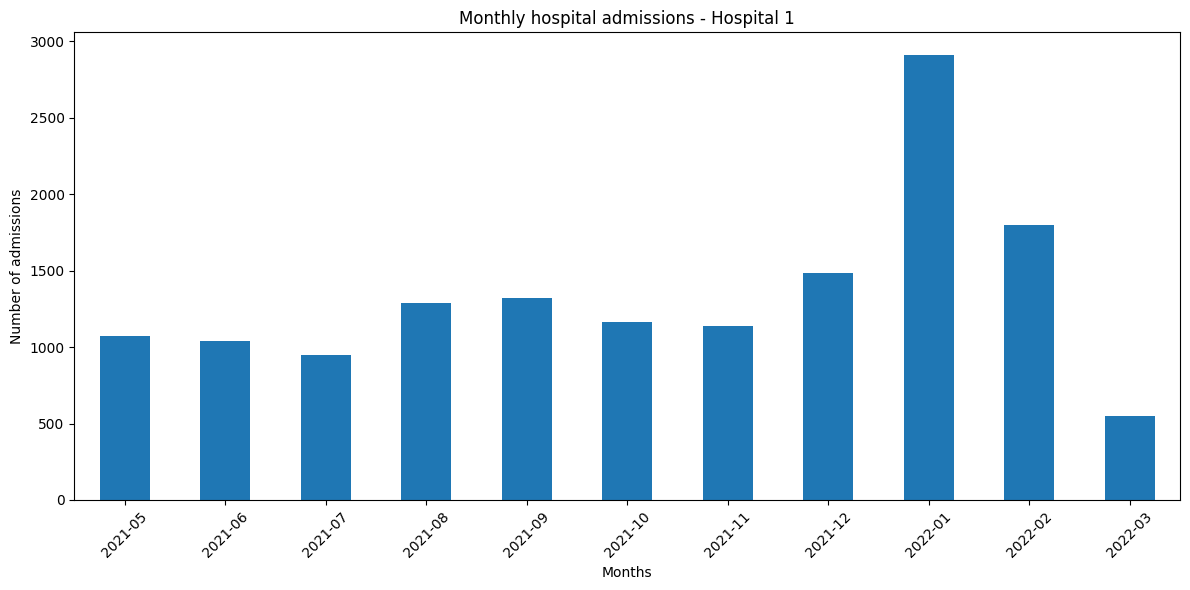

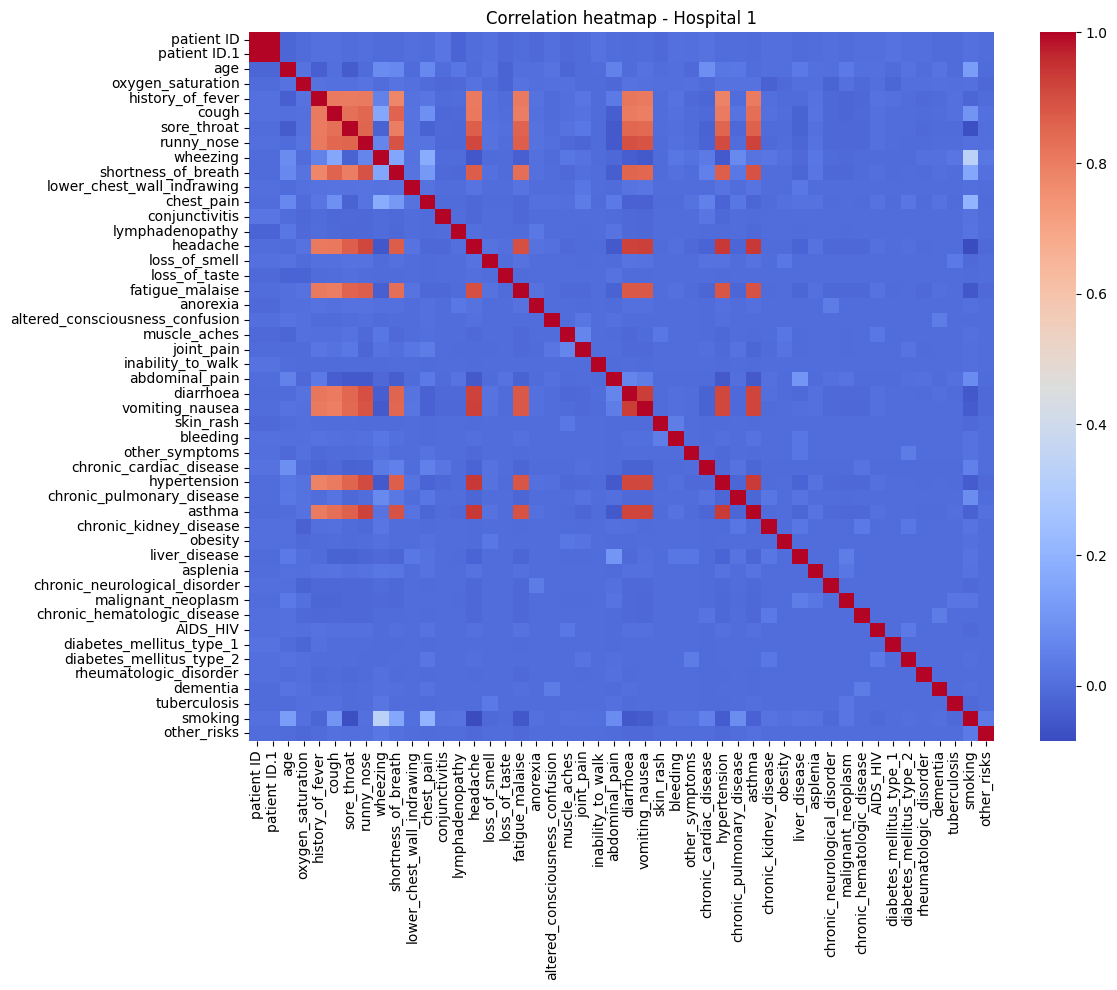

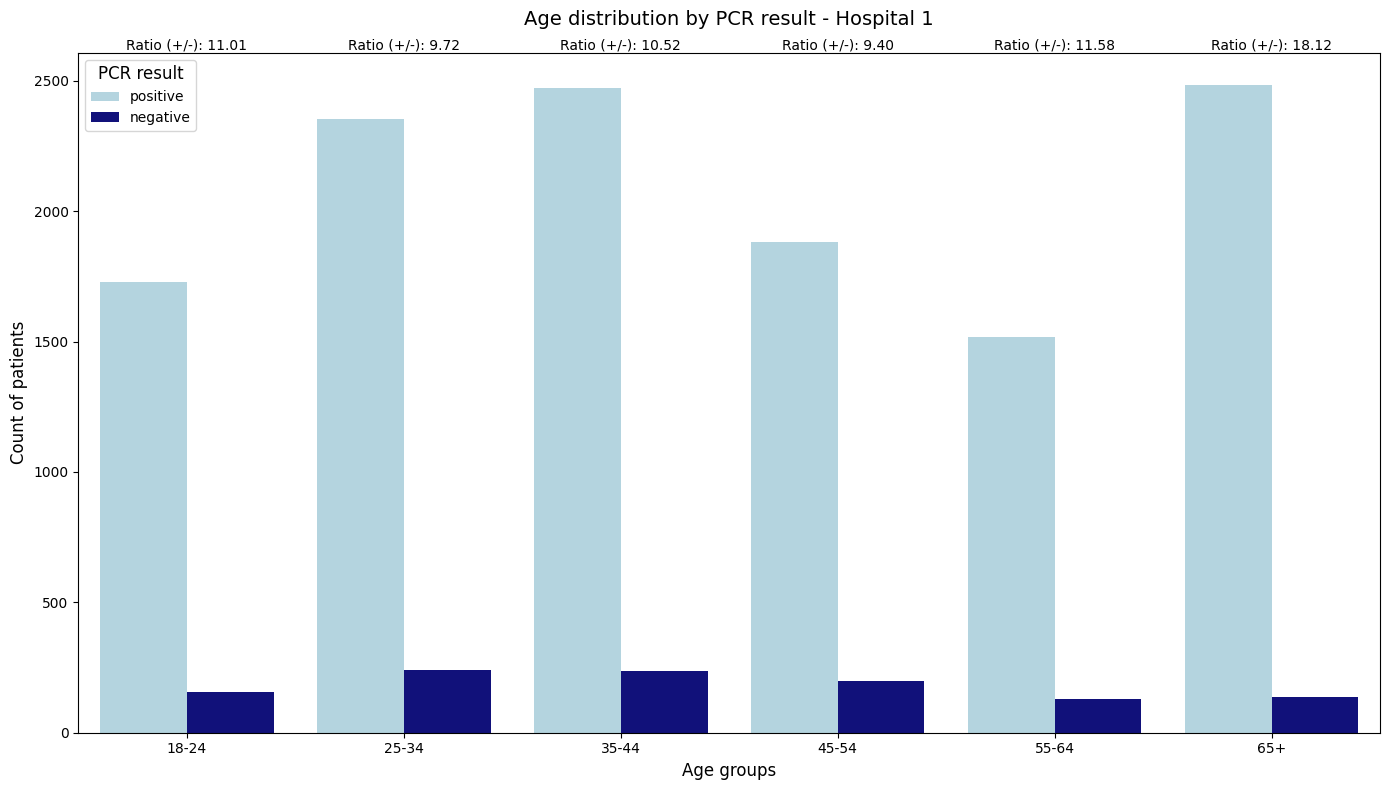

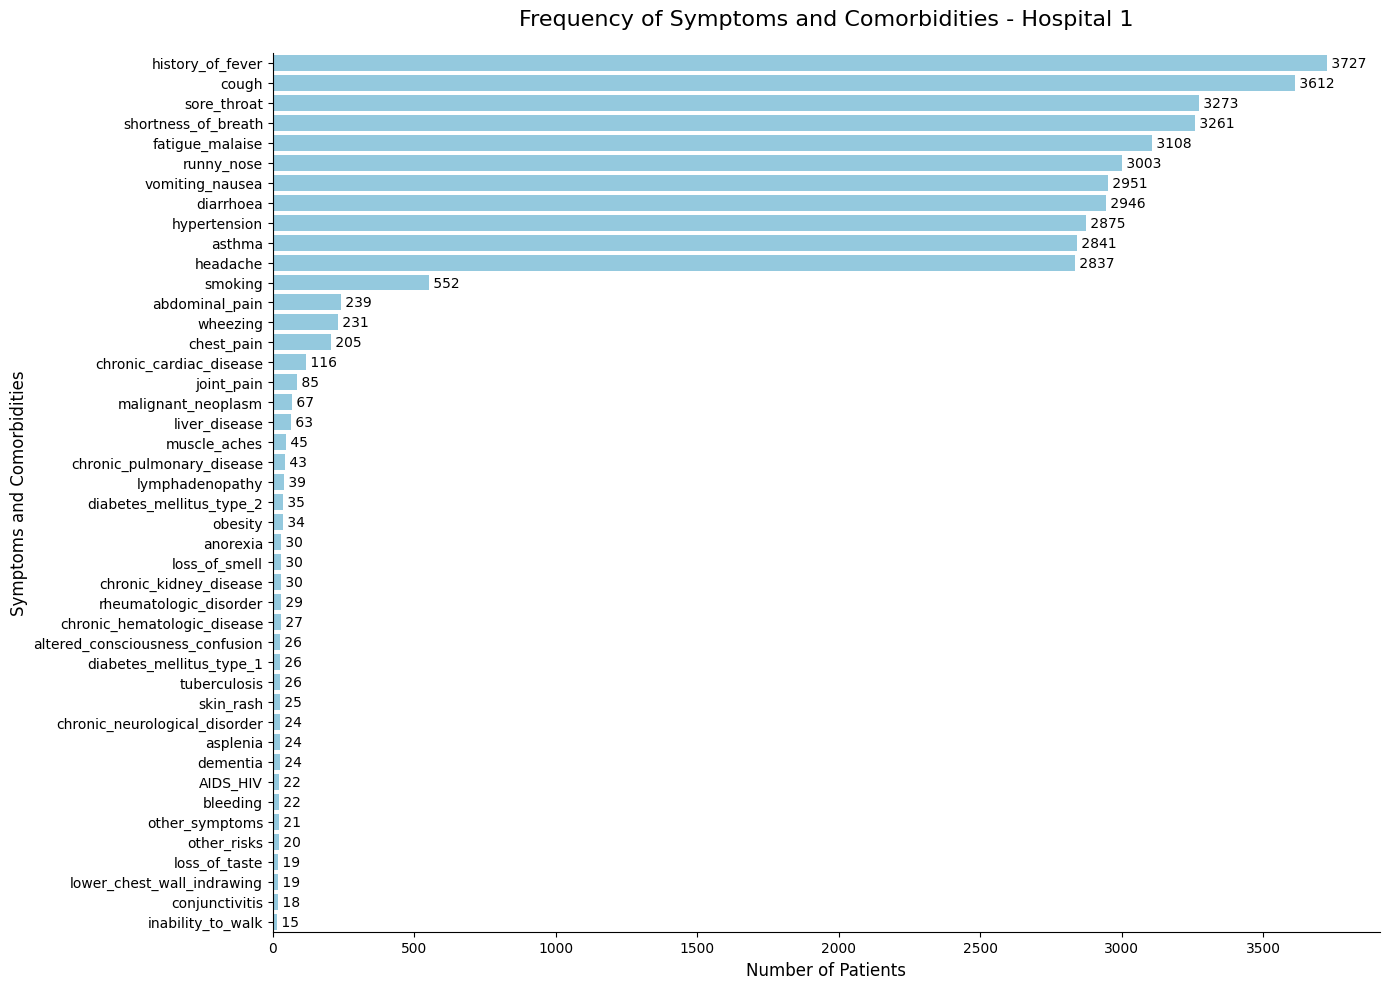

In [5]:
# 2.1 Perform EDA function for hospital1
perform_eda(hospital1, "Hospital 1")

*Hospital 1 observations:*

**Data size:** The dataset contains 14 712 records with 54 columns (original dataset).

**Missing values:** There are significant missing values in the 'fever_temperature' (468) and 'PCR_result' (1 176) columns. This may impact analyses involving these variables.

**Monthly admissions:** There's a clear trend in hospital admissions over time, with a peak observed around January 2022. This could indicate seasonal patterns in COVID-19 cases (Timeframe: 05.2021-03.2022).

**Correlations between variables:** Strong positive correlations are observed between some symptoms (e.g., cough, sore throat, runny nose, vomiting nausea, diarrhoea, hypertension and asthma), suggesting these often occur together in patients.

**Age distribution by PCR result:** The 25-34 and 35-44 age groups show the highest number of positive PCR results. The proportion of positive and negative cases varies greatly between age groups, especially in the over-65s.

**Symptoms and comorbidities:** History of fever is the most frequent symptom, followed by cough and sore throat. Hypertension is the most common comorbidity.


--- Hospital 2 data set analysis ---

Data set size:
(12737, 54)

Columns and data types:
patient_id                         float64
admission_id                       float64
country_of_residence                object
age                                float64
sex                                 object
date_of_first_symptoms              object
admission_date                      object
fever_temperature                   object
oxygen_saturation                  float64
history_of_fever                   float64
cough                              float64
sore_throat                        float64
runny_nose                         float64
wheezing                           float64
shortness_of_breath                float64
lower_chest_wall_indrawing         float64
chest_pain                         float64
conjunctivitis                     float64
lymphadenopathy                    float64
headache                           float64
loss_of_smell                      float64
loss_o

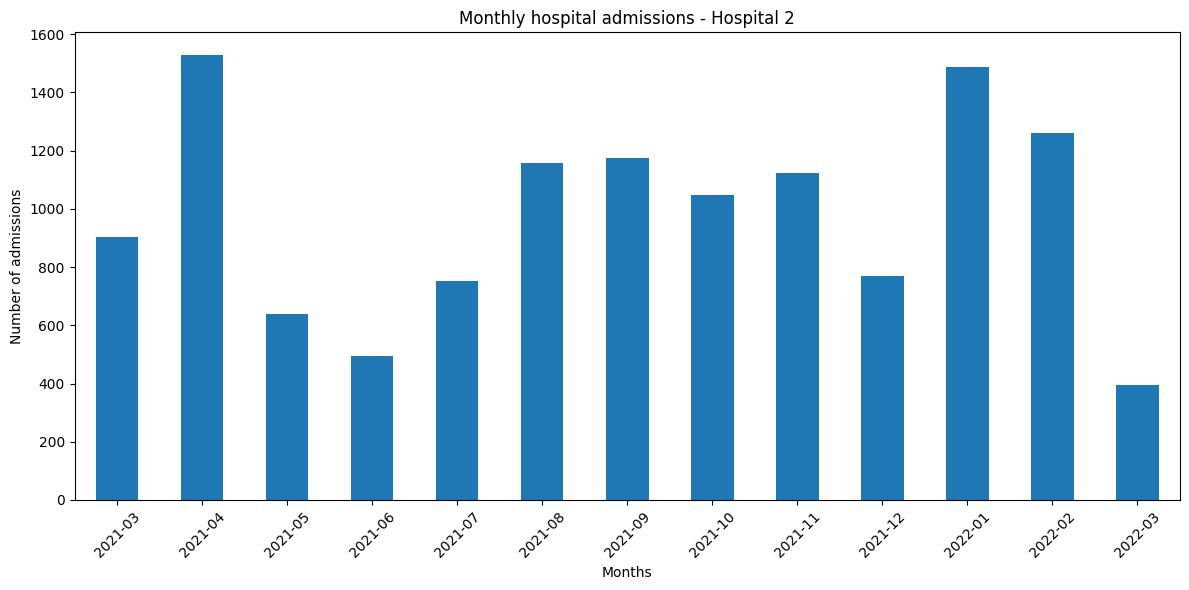

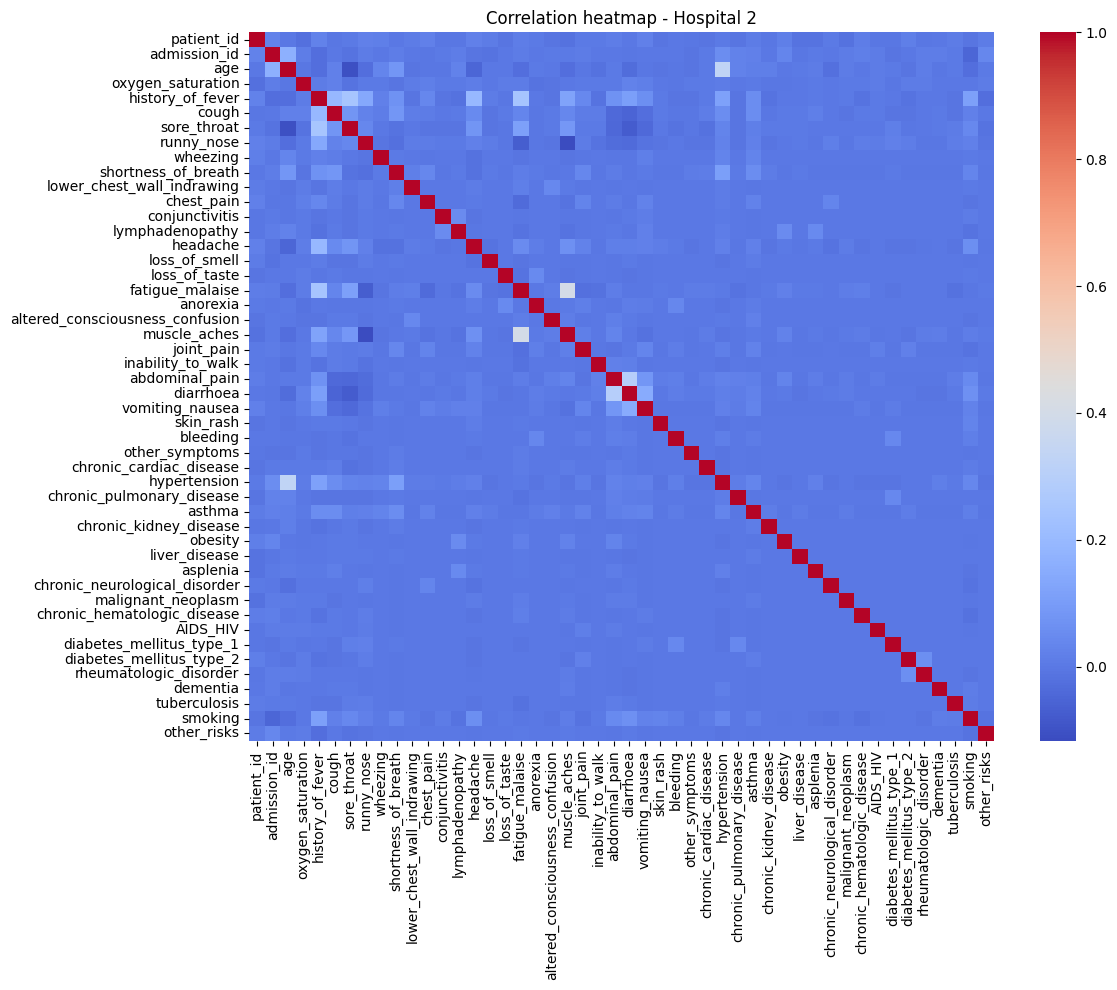

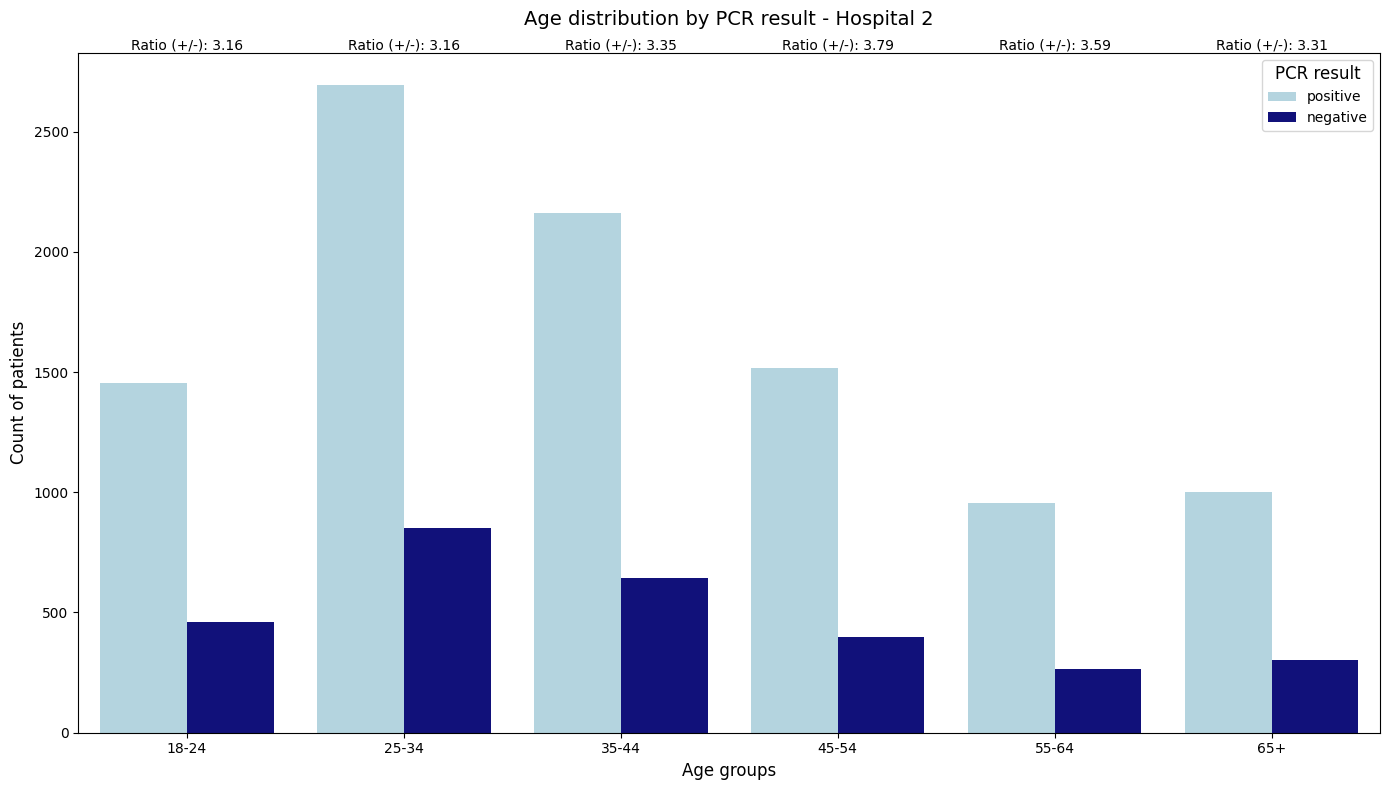

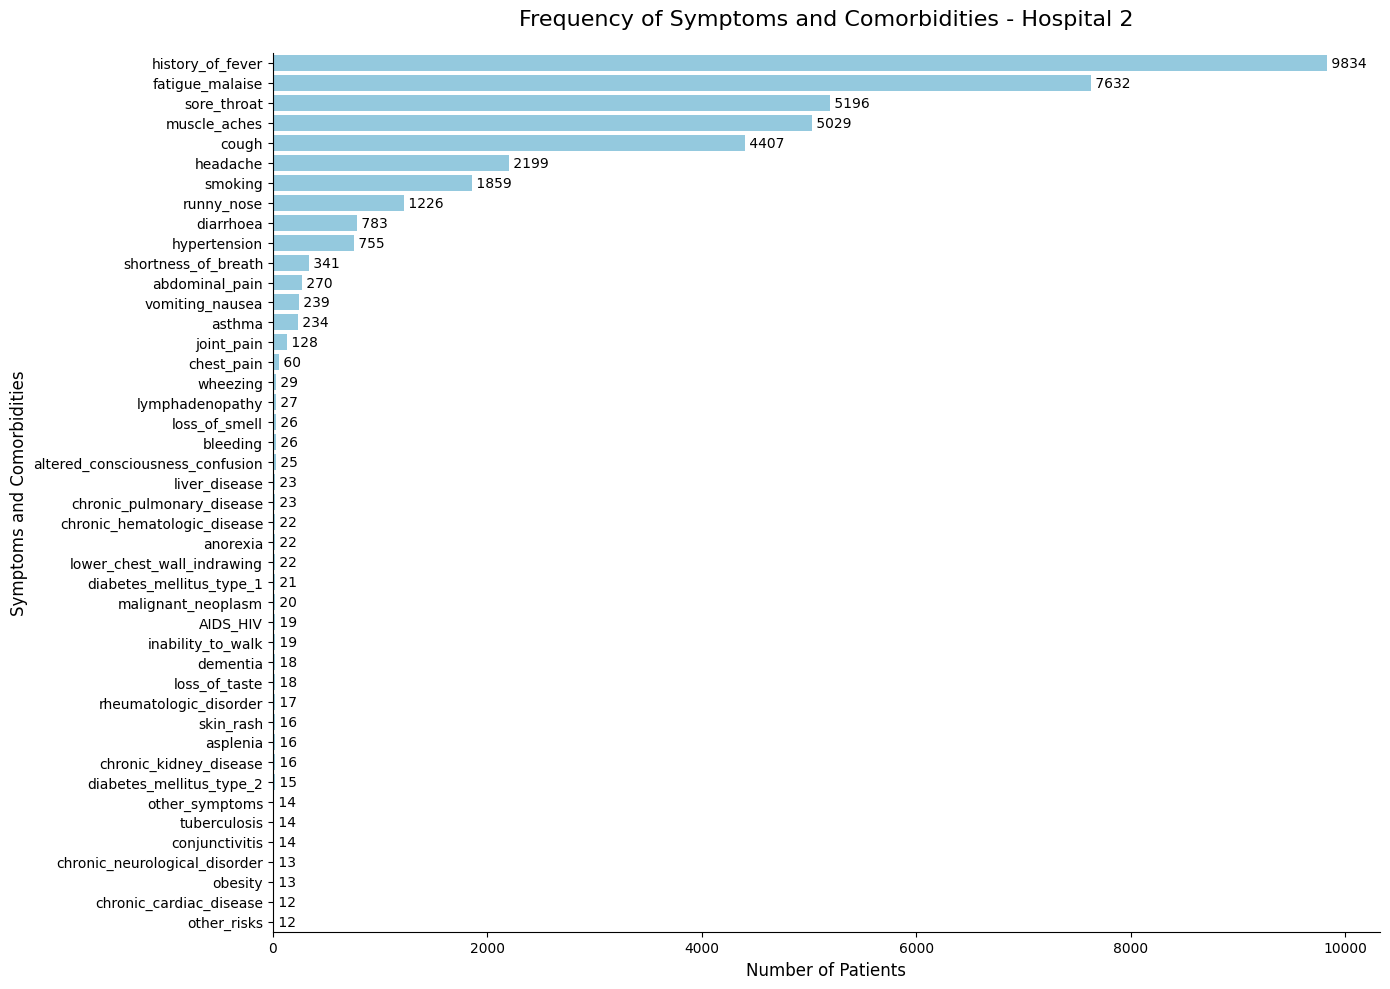

In [6]:
# 2.2 Perform EDA function for hospital2

perform_eda(hospital2, "Hospital 2")

*Hospital 2 observations:*

**Data size:** The dataset contains 12 736 records with 54 columns.

**Missing values:** There are missing values in several columns, with 'fever_temperature' having the most (1 221). One crucial observation regarding the patient_id, there are also 3 rows where it is empty, those need to be deleted as they are not containing any data.

**Monthly admissions:** The trend shows a peak in admissions around April 2021, and similar to Hospital 1 in January 2022, but this dataset has records in a greater timeframe compared to Hospital 1 (03.2021-03.2022).

**Correlations between variables:** Unlike in Hospital 1, correlations between certain symptoms and comorbidities are not significant at all.

**Age distribution by PCR result:** The age distribution of positive PCR results is more evenly spread across age groups compared to Hospital 1, with the 25-34 group showing the highest number of positive cases. The proportion of positive and negative cases is almost constant for each age group.

**Symptoms and comorbidities:** History of fever is also the most frequent symptom in Hospital 2, but the order and frequency of other symptoms and comorbidities differ from Hospital 1.

In [7]:
# 3. Checking rows where patient_id is missing
print(hospital1[hospital1['patient ID'].isnull()]) #0 result
print(hospital2[hospital2['patient_id'].isnull()]) #3 results

Empty DataFrame
Columns: [patient ID, patient ID.1, nationality, age, gender K=female E=male, date_of_first_symptoms, BASVURUTARIHI, fever_temperature, oxygen_saturation, history_of_fever, cough, sore_throat, runny_nose, wheezing, shortness_of_breath, lower_chest_wall_indrawing, chest_pain, conjunctivitis, lymphadenopathy, headache, loss_of_smell, loss_of_taste, fatigue_malaise, anorexia, altered_consciousness_confusion, muscle_aches, joint_pain, inability_to_walk, abdominal_pain, diarrhoea, vomiting_nausea, skin_rash, bleeding, other_symptoms, chronic_cardiac_disease, hypertension, chronic_pulmonary_disease, asthma, chronic_kidney_disease, obesity, liver_disease, asplenia, chronic_neurological_disorder, malignant_neoplasm, chronic_hematologic_disease, AIDS_HIV, diabetes_mellitus_type_1, diabetes_mellitus_type_2, rheumatologic_disorder, dementia, tuberculosis, smoking, other_risks, PCR_result, admission_month, age_group]
Index: []
       patient_id  admission_id country_of_residence  a

In [8]:
# 4. Checking column oxygen_saturation - this takes up values which are unlikely to happen in real life settings.

# List of hospitals to iterate through
hospitals = [("hospital1", hospital1), ("hospital2", hospital2)]

# Iterate over each hospital and perform the checks
for name, data in hospitals:
    print(f"Unique values for oxygen saturation in {name}: {data['oxygen_saturation'].unique()}")
    print(f"Empty cells for oxygen saturation in {name}: {data['oxygen_saturation'].isnull().sum()}")
    print(f"Value 0 for oxygen saturation in {name}: {data[data['oxygen_saturation'] == 0].shape[0]}")
    print(f"Value -1 for oxygen saturation in {name}: {data[data['oxygen_saturation'] == -1].shape[0]}")

Unique values for oxygen saturation in hospital1: [ 96.  95.  98.  90.  80.  86.  94.  88.  89.  85.  97.   0.  87.  92.
  78.  99.  91. 100.  93.  81.  79.  82.  77.  84.  83.  69.  76.  70.
  -1.  71.  nan]
Empty cells for oxygen saturation in hospital1: 4
Value 0 for oxygen saturation in hospital1: 62
Value -1 for oxygen saturation in hospital1: 16
Unique values for oxygen saturation in hospital2: [ nan  -1.  95.  88.  87.  89.  94.  96.  90.  78.  97.  99.  86.  93.
  79.  98.  91.  80.  92.  81. 100.  85.   0.  82.  84.  70.  83.  77.
  71.  69.  76.  73.  68.  26.]
Empty cells for oxygen saturation in hospital2: 7
Value 0 for oxygen saturation in hospital2: 49
Value -1 for oxygen saturation in hospital2: 16


In [9]:
# 5. Checking column PCR_result in both hospitals

# Iterate over each hospital and perform the checks
for name, data in hospitals:
    print(f"Empty cells for PCR results in {name}: {data['PCR_result'].isnull().sum()}")

Empty cells for PCR results in hospital1: 1176
Empty cells for PCR results in hospital2: 34


*Key takeaways from EDA:*

**Data quailty:** Both datasets have missing values, particularly in important columns like fever temperature and PCR result. This needs to be addressed in the data preprocessing stage.

**Patterns:** Both hospitals show similar seasonal trends in admissions, which could be valuable for predicting future COVID-19 waves.

**Age related insights:** There is a variation in the age breakdown of positive PCR individuals between the two hospitals, which could be due to the variations in the populations or the testing practices employed.

**Symptom/comorbidity profiles:** In both datasets history_of_fever was the most frequent symptom and hypertension the most frequent comorbidity. These could inform targeted screening protocols. But the prevalence of other comorbidities differs between the two hospitals, which might impact treatment strategies and resource allocation.

**Data structure differences:** There are slight differences between the headers and also in Hospital 1 there is no admission ID which will be added in the preprocessing section. Also the standardized name of the headers will be handled.

## 5. Data Preprocessing

In [10]:
# 1. Firstly, create copies of the original dataframes to avoid modifying them directly
hospital1_std = hospital1.copy()
hospital2_std = hospital2.copy()

In [11]:
# 2. Deleting the rows without patient_id in hospital2
hospital2_std.dropna(subset={'patient_id'},inplace=True)

In [12]:
# 3.1 Standardize column names - determining which columns have to be renamed to be the same in both datasets
column_mapping_hospital1 = {
    'patient ID': 'patient_id',
    'patient ID.1': 'admission_id',
    'nationality': 'country_of_residence',
    'gender K=female E=male': 'sex',
    'BASVURUTARIHI': 'admission_date'
}

column_mapping_hospital2 = {
    'patient_id': 'patient_id',
    'admission_id': 'admission_id',
    'country_of_residence': 'country_of_residence',
    'sex': 'sex',
    'admission_date': 'admission_date'
}

In [13]:
# 3.2 Rename columns which had to be standardized before merging
hospital1_std.rename(columns=column_mapping_hospital1, inplace=True)
hospital2_std.rename(columns=column_mapping_hospital2, inplace=True)

In [14]:
# 4. Handle gender/sex encoding - to be numerical binary data (for later not to be a problem that it is not a number)

# Convert K/E to standardized format (0/1)
hospital1_std['sex'] = hospital1_std['sex'].map({'K': 0, 'E': 1})
# Assuming hospital2 might have 'F'/'M' or other format, standardize it
hospital2_std['sex'] = hospital2_std['sex'].map({'K': 0, 'E': 1,'E=male K=female':1})

In [15]:
# 5. Convert admission dates and date of first symptoms to date format - easier to handle

#Hospital 1 admission_date convertion into date
hospital1_std['admission_date'] = pd.to_datetime(hospital1_std['admission_date'])
hospital1_std['admission_date'] = hospital1_std['admission_date'].dt.date

#Hospital 2 admission_date convertion into date
hospital2_std['admission_date'] = pd.to_datetime(hospital2_std['admission_date'])
hospital2_std['admission_date'] = hospital2_std['admission_date'].dt.date

#Hospital 1 date_of_first_symptoms convertion into date
hospital1_std['date_of_first_symptoms'] = pd.to_datetime(hospital1_std['date_of_first_symptoms'])
hospital1_std['date_of_first_symptoms'] = hospital1_std['date_of_first_symptoms'].dt.date

#Hospital 2 date_of_first_symptoms convertion into date
hospital2_std['date_of_first_symptoms'] = pd.to_datetime(hospital2_std['date_of_first_symptoms'])
hospital2_std['date_of_first_symptoms'] = hospital2_std['date_of_first_symptoms'].dt.date

In [16]:
# 6. Column 'fever_temperature' has to be modified as it contains commas instead of points.

# Step 1: Convert 'fever_temperature' to string first
hospital1_std['fever_temperature'] = hospital1_std['fever_temperature'].astype(str)
hospital2_std['fever_temperature'] = hospital2_std['fever_temperature'].astype(str)

# Step 2: Replace commas with points
hospital1_std['fever_temperature'] = hospital1_std['fever_temperature'].str.replace(',', '.')
hospital2_std['fever_temperature'] = hospital2_std['fever_temperature'].str.replace(',', '.')

# Step 3: Convert 'fever_temperature' back to numeric (float), coercing errors to NaN
hospital1_std['fever_temperature'] = pd.to_numeric(hospital1_std['fever_temperature'], errors='coerce')
hospital2_std['fever_temperature'] = pd.to_numeric(hospital2_std['fever_temperature'], errors='coerce')

In [17]:
# 7. Check for missing values again in both datasets
print(hospital1_std.isnull().sum())
print(hospital2_std.isnull().sum())

patient_id                            0
admission_id                          0
country_of_residence                  0
age                                   0
sex                                   0
date_of_first_symptoms                0
admission_date                        0
fever_temperature                   468
oxygen_saturation                     4
history_of_fever                      0
cough                                 0
sore_throat                           0
runny_nose                            0
wheezing                              0
shortness_of_breath                   0
lower_chest_wall_indrawing            0
chest_pain                            0
conjunctivitis                        0
lymphadenopathy                       0
headache                              0
loss_of_smell                         0
loss_of_taste                         0
fatigue_malaise                       0
anorexia                              0
altered_consciousness_confusion       0


In [18]:
# 8. Imputation of missing values and substitute invalid values

# Step 1: Define a function to replace invalid values with NaN

def replace_invalid_values(df, column, invalid_values):
    df[column] = df[column].replace(invalid_values, np.nan)

invalid_values = [0, -1] # List of invalid values to replace

replace_invalid_values(hospital1_std, 'oxygen_saturation', invalid_values) # Replace invalid values in hospital1 (EDA 4th section showed the problem)
replace_invalid_values(hospital2_std, 'oxygen_saturation', invalid_values) # Replace invalid values in hospital2 (EDA 4th section showed the problem)

# Step 2: Impute missing values for numerical columns using mean
imputer = SimpleImputer(strategy='mean')
hospital1_std[['fever_temperature', 'oxygen_saturation']] = imputer.fit_transform(
    hospital1_std[['fever_temperature', 'oxygen_saturation']]
)
hospital2_std[['fever_temperature', 'oxygen_saturation']] = imputer.fit_transform(
    hospital2_std[['fever_temperature', 'oxygen_saturation']]
)

# Step 3: Impute missing values for binary columns using median
imputer = SimpleImputer(strategy='most_frequent')
hospital1_std[['chronic_kidney_disease', 'obesity', 'liver_disease','history_of_fever','bleeding','other_symptoms','asplenia','chronic_neurological_disorder','chronic_hematologic_disease','AIDS_HIV','diabetes_mellitus_type_1','diabetes_mellitus_type_2','rheumatologic_disorder','dementia']] = imputer.fit_transform(
    hospital1_std[['chronic_kidney_disease', 'obesity', 'liver_disease','history_of_fever','bleeding','other_symptoms','asplenia','chronic_neurological_disorder','chronic_hematologic_disease','AIDS_HIV','diabetes_mellitus_type_1','diabetes_mellitus_type_2','rheumatologic_disorder','dementia']]
)
hospital2_std[['chronic_kidney_disease', 'obesity', 'liver_disease','history_of_fever','bleeding','other_symptoms','asplenia','chronic_neurological_disorder','chronic_hematologic_disease','AIDS_HIV','diabetes_mellitus_type_1','diabetes_mellitus_type_2','rheumatologic_disorder','dementia']] = imputer.fit_transform(
    hospital2_std[['chronic_kidney_disease', 'obesity', 'liver_disease','history_of_fever','bleeding','other_symptoms','asplenia','chronic_neurological_disorder','chronic_hematologic_disease','AIDS_HIV','diabetes_mellitus_type_1','diabetes_mellitus_type_2','rheumatologic_disorder','dementia']]
)


# Step 4: Drop rows with NaN in PCR_result for both hospital1 and hospital2
hospital1_std = hospital1_std.dropna(subset=['PCR_result']) # EDA 5th section showed the problem
hospital2_std = hospital2_std.dropna(subset=['PCR_result']) # EDA 5th section showed the problem

# Map PCR_result to numerical values: 'positive' -> 1, 'negative' -> 0
hospital1_std.loc[:, 'PCR_result'] = hospital1_std['PCR_result'].map({'positive': 1, 'negative': 0})
hospital2_std.loc[:, 'PCR_result'] = hospital2_std['PCR_result'].map({'positive': 1, 'negative': 0})


In [19]:
# 9. Create same format of numbers in both datasets

# Step 1: Excluding 'fever_temperature' beacuse it was given as float
exclude_columns = ['fever_temperature'] #because it is truly float in the original dataset

# Step 2: Determining float columns in both datasets
float_columns_hospital1 = hospital1_std.select_dtypes(include=['float']).columns.difference(exclude_columns)
float_columns_hospital2 = hospital2_std.select_dtypes(include=['float']).columns.difference(exclude_columns)

# Step 3: Converting float columns into integers
hospital1_std[float_columns_hospital1] = hospital1_std[float_columns_hospital1].astype(int)
hospital2_std[float_columns_hospital2] = hospital2_std[float_columns_hospital2].astype(int)

In [20]:
# 10. Create standardized admission IDs for hospital1 and hospital2

                          #Dataset: hospital1
# Step 1: Sort the dataset by patient_id
hospital1_std = hospital1_std.sort_values(by='patient_id').reset_index(drop=True)

# Step 2: Create a temporary ID column (sequential numbers)
hospital1_std['temporary_id'] = range(1, len(hospital1_std) + 1)

# Step 3: Concatenate patient_id and temporary_id into a admission_id
hospital1_std['admission_id'] = hospital1_std['patient_id'].astype(str) + '_' + hospital1_std['temporary_id'].astype(str)

# Step 4: drop temporary_id from hospital1 as it is not needed from now on
hospital1_std.drop(columns=['temporary_id'], inplace=True)

                          #Dataset: hospital2
# Step 1: Concatenate patient_id and admission_id to have a common structure in both datasets
hospital2_std['admission_id'] = hospital2_std['patient_id'].astype(str) + '_' + hospital2_std['admission_id'].astype(str)


In [21]:
# 11. Verify the standardization with column names
print("Hospital 1 columns after standardization:")
print(hospital1_std.columns.tolist())
print("\nHospital 2 columns after standardization:")
print(hospital2_std.columns.tolist())

Hospital 1 columns after standardization:
['patient_id', 'admission_id', 'country_of_residence', 'age', 'sex', 'date_of_first_symptoms', 'admission_date', 'fever_temperature', 'oxygen_saturation', 'history_of_fever', 'cough', 'sore_throat', 'runny_nose', 'wheezing', 'shortness_of_breath', 'lower_chest_wall_indrawing', 'chest_pain', 'conjunctivitis', 'lymphadenopathy', 'headache', 'loss_of_smell', 'loss_of_taste', 'fatigue_malaise', 'anorexia', 'altered_consciousness_confusion', 'muscle_aches', 'joint_pain', 'inability_to_walk', 'abdominal_pain', 'diarrhoea', 'vomiting_nausea', 'skin_rash', 'bleeding', 'other_symptoms', 'chronic_cardiac_disease', 'hypertension', 'chronic_pulmonary_disease', 'asthma', 'chronic_kidney_disease', 'obesity', 'liver_disease', 'asplenia', 'chronic_neurological_disorder', 'malignant_neoplasm', 'chronic_hematologic_disease', 'AIDS_HIV', 'diabetes_mellitus_type_1', 'diabetes_mellitus_type_2', 'rheumatologic_disorder', 'dementia', 'tuberculosis', 'smoking', 'other

In [22]:
# Bonus: Check unique values in standardized columns to verify encoding
print("Unique values in sex column (Hospital 1):\n", hospital1_std['sex'].unique())
print("Unique values in sex column (Hospital 2):\n", hospital2_std['sex'].unique())

Unique values in sex column (Hospital 1):
 [0 1]
Unique values in sex column (Hospital 2):
 [1 0]


In [23]:
# 12. Checking the DataTypes of the two DataSets

# Step 1: Extracting column names and data types
hospital1_info = pd.DataFrame({'hospital1_cols': hospital1_std.columns,'hospital1_cols_dtype': hospital1_std.dtypes.astype(str)})
hospital2_info = pd.DataFrame({'hospital2_cols': hospital2_std.columns,'hospital2_cols_dtype': hospital2_std.dtypes.astype(str)})

# Step 2: Merging the two info DataFrames by column names to align them side by side
combined_info = pd.merge(hospital1_info, hospital2_info,left_on='hospital1_cols',right_on='hospital2_cols')

# Step 3: Adding a comparison column to check if the datatypes are the same
combined_info['Are the dtypes the same?'] = (combined_info['hospital1_cols_dtype'] == combined_info['hospital2_cols_dtype'])

# Step 4: Displaying the resulting DataFrame
combined_info

,hospital1_cols,hospital1_cols_dtype,hospital2_cols,hospital2_cols_dtype,Are the dtypes the same?
0,patient_id,int64,patient_id,int32,False
1,admission_id,object,admission_id,object,True
2,country_of_residence,object,country_of_residence,object,True
3,age,int64,age,int32,False
4,sex,int64,sex,int64,True
5,date_of_first_symptoms,object,date_of_first_symptoms,object,True
6,admission_date,object,admission_date,object,True
7,fever_temperature,float64,fever_temperature,float64,True
8,oxygen_saturation,int32,oxygen_saturation,int32,True
9,history_of_fever,int32,history_of_fever,int32,True


### Now all the columns in both datasets are in the same formats! (NOTE: int64 and int32 are not a problem as they are binary variables)

### Let's merge the two of them!

In [24]:
# 13. Merge the datasetsm getting information about it

# Step 1: Merge
combined_data = pd.concat([hospital1_std, hospital2_std], axis=0, ignore_index=True)

# Step 2: Information
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26237 entries, 0 to 26236
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype    
---  ------                           --------------  -----    
 0   patient_id                       26237 non-null  int64    
 1   admission_id                     26237 non-null  object   
 2   country_of_residence             26237 non-null  object   
 3   age                              26237 non-null  int64    
 4   sex                              26237 non-null  int64    
 5   date_of_first_symptoms           26237 non-null  object   
 6   admission_date                   26237 non-null  object   
 7   fever_temperature                26237 non-null  float64  
 8   oxygen_saturation                26237 non-null  int32    
 9   history_of_fever                 26237 non-null  int32    
 10  cough                            26237 non-null  int64    
 11  sore_throat                      26237 non-null  int64

In [25]:
# 14. Check that there is no missing values in the merged dataset

combined_data.isnull().sum()

patient_id                         0
admission_id                       0
country_of_residence               0
age                                0
sex                                0
date_of_first_symptoms             0
admission_date                     0
fever_temperature                  0
oxygen_saturation                  0
history_of_fever                   0
cough                              0
sore_throat                        0
runny_nose                         0
wheezing                           0
shortness_of_breath                0
lower_chest_wall_indrawing         0
chest_pain                         0
conjunctivitis                     0
lymphadenopathy                    0
headache                           0
loss_of_smell                      0
loss_of_taste                      0
fatigue_malaise                    0
anorexia                           0
altered_consciousness_confusion    0
muscle_aches                       0
joint_pain                         0
i

## 6. Model training

In [26]:
# Identify non-numerical columns

non_numeric_columns = combined_data.select_dtypes(include=['object']).columns
print(f"Non-numerical columns: {non_numeric_columns}")

Non-numerical columns: Index(['admission_id', 'country_of_residence', 'date_of_first_symptoms',
       'admission_date', 'PCR_result', 'age_group'],
      dtype='object')


In [27]:
# Since country_of_residence has many unique values and encoding issues, it is reasonable to drop this column

combined_data_forM = combined_data
combined_data_forM.drop(columns=['country_of_residence'], inplace=True)

In [28]:
# Convert date columns to datetime format
combined_data_forM['admission_date'] = pd.to_datetime(combined_data_forM['admission_date'], errors='coerce')
combined_data_forM['date_of_first_symptoms'] = pd.to_datetime(combined_data_forM['date_of_first_symptoms'], errors='coerce')

# Extract features from 'admission_date'
combined_data_forM['admission_year'] = combined_data_forM['admission_date'].dt.year
combined_data_forM['admission_month'] = combined_data_forM['admission_date'].dt.month
combined_data_forM['admission_day_of_week'] = combined_data_forM['admission_date'].dt.dayofweek  # 0 = Monday, 6 = Sunday
combined_data_forM['admission_day_of_month'] = combined_data_forM['admission_date'].dt.day

# Extract features from 'date_of_first_symptoms'
combined_data_forM['symptom_year'] = combined_data_forM['date_of_first_symptoms'].dt.year
combined_data_forM['symptom_month'] = combined_data_forM['date_of_first_symptoms'].dt.month
combined_data_forM['symptom_day_of_week'] = combined_data_forM['date_of_first_symptoms'].dt.dayofweek
combined_data_forM['symptom_day_of_month'] = combined_data_forM['date_of_first_symptoms'].dt.day

# Drop original date columns if no longer needed
combined_data_forM.drop(columns=['admission_date', 'date_of_first_symptoms'], inplace=True)

In [29]:
# Encode months as cyclical features
combined_data_forM['admission_month_sin'] = np.sin(2 * np.pi * combined_data_forM['admission_month'] / 12)
combined_data_forM['admission_month_cos'] = np.cos(2 * np.pi * combined_data_forM['admission_month'] / 12)

# Encode days of the week as cyclical features
combined_data_forM['admission_day_of_week_sin'] = np.sin(2 * np.pi * combined_data_forM['admission_day_of_week'] / 7)
combined_data_forM['admission_day_of_week_cos'] = np.cos(2 * np.pi * combined_data_forM['admission_day_of_week'] / 7)

# Drop the original month and day columns if no longer needed
combined_data_forM.drop(columns=['admission_month', 'admission_day_of_week'], inplace=True)

In [30]:
# Select numerical columns for normalization - THIS JUST MADE THE RESULTS WORSE
#numerical_columns = ['age', 'fever_temperature', 'oxygen_saturation']
#scaler = MinMaxScaler()
#combined_data_forM[numerical_columns] = scaler.fit_transform(combined_data_forM[numerical_columns])

In [31]:
# Defining features and target variables

combined_data_forM['PCR_result'] = combined_data_forM['PCR_result'].astype(int) #set to int in order not to have error during training

target = 'PCR_result'

X = combined_data_forM.drop(columns=[target, 'patient_id', 'admission_id','age_group']) #
Y = combined_data_forM[target] #Target: PCR result

In [32]:
print(combined_data_forM[combined_data_forM['age_group'].isnull()])

Empty DataFrame
Columns: [patient_id, admission_id, age, sex, fever_temperature, oxygen_saturation, history_of_fever, cough, sore_throat, runny_nose, wheezing, shortness_of_breath, lower_chest_wall_indrawing, chest_pain, conjunctivitis, lymphadenopathy, headache, loss_of_smell, loss_of_taste, fatigue_malaise, anorexia, altered_consciousness_confusion, muscle_aches, joint_pain, inability_to_walk, abdominal_pain, diarrhoea, vomiting_nausea, skin_rash, bleeding, other_symptoms, chronic_cardiac_disease, hypertension, chronic_pulmonary_disease, asthma, chronic_kidney_disease, obesity, liver_disease, asplenia, chronic_neurological_disorder, malignant_neoplasm, chronic_hematologic_disease, AIDS_HIV, diabetes_mellitus_type_1, diabetes_mellitus_type_2, rheumatologic_disorder, dementia, tuberculosis, smoking, other_risks, PCR_result, age_group, admission_year, admission_day_of_month, symptom_year, symptom_month, symptom_day_of_week, symptom_day_of_month, admission_month_sin, admission_month_cos,

In [33]:
# Splitting dataset into training and testing sets to evaluate model performance

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [34]:
# Initializing the model

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model

model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [35]:
X_train.isnull().sum()

age                                0
sex                                0
fever_temperature                  0
oxygen_saturation                  0
history_of_fever                   0
cough                              0
sore_throat                        0
runny_nose                         0
wheezing                           0
shortness_of_breath                0
lower_chest_wall_indrawing         0
chest_pain                         0
conjunctivitis                     0
lymphadenopathy                    0
headache                           0
loss_of_smell                      0
loss_of_taste                      0
fatigue_malaise                    0
anorexia                           0
altered_consciousness_confusion    0
muscle_aches                       0
joint_pain                         0
inability_to_walk                  0
abdominal_pain                     0
diarrhoea                          0
vomiting_nausea                    0
skin_rash                          0
b

In [36]:
# Generate predictions for X_test
y_pred = model.predict(X_test)
# Generate a classification report
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.52      0.61       815
           1       0.92      0.96      0.94      4433

    accuracy                           0.90      5248
   macro avg       0.82      0.74      0.77      5248
weighted avg       0.89      0.90      0.89      5248



### **Class breakdown**
**Negative (0) PCR result:**
*   Precision -> 73% of predictions for 'negative' are correct.
*   Recall -> Only 52% of actual 'negative' cases are identified correctly.
* F1-score -> 0.61: Moderate performance for this class.

**Positive (1) PCR result:**
*   Precision -> 92% of predictions for 'positive' are correct.
*   Recall -> 96% of actual 'positive' cases are identified correctly.
* F1-score -> 0.94: Excellent performance for this class.

## **Overall metrics**

**Accuracy:** The model's ability to accurately predict 90% of the entire set of test samples, is satisfactory in general.

**Macro average:** When all classes are treated equally, irrespective of their prevalence, the figures for precision (0.82) and recall (0.74) indicate good performance, though there remains an opportunity to enhance recall for negative cases.

**Weighted average:** The preservation of imbalance in the class distribution (for instance, a greater number of samples in Class 1) improves the results of Precision (0.89) and Recall (0.90).

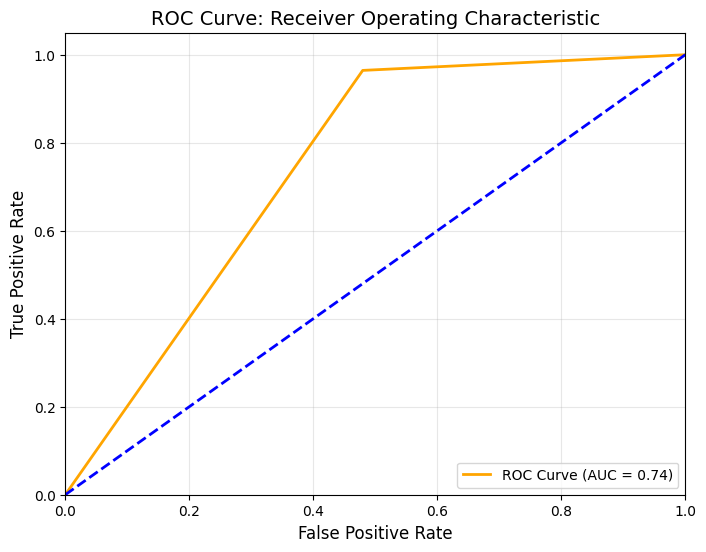

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
#ROC curve
# Assuming Y_test contains actual labels and y_pred_prob holds predicted probabilities for the positive class
false_positive_rate, true_positive_rate, threshold_values = roc_curve(Y_test, y_pred)
roc_auc_value = roc_auc_score(Y_test, y_pred)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, color='orange', linewidth=2,
         label=f'ROC Curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', linewidth=2)  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve: Receiver Operating Characteristic', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## 7. Feature importance

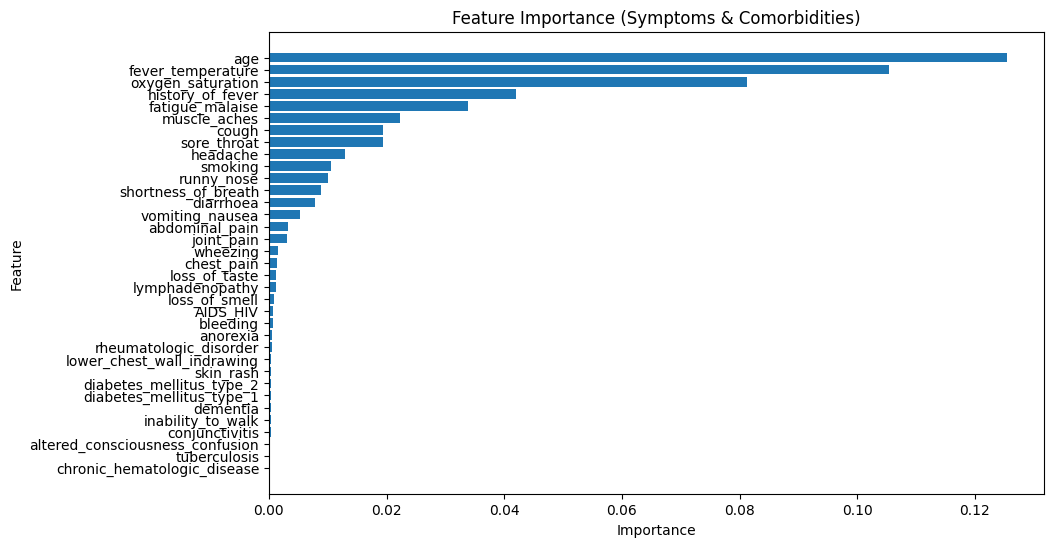

In [38]:
# Extract feature importance - Get feature importance from the model

# Get feature importance from the model
feature_importances = model.feature_importances_ #'_' -> the model calculated this value during its training

# Filter only symptom and comorbidity columns
symptom_comorbidity_columns = [
    'fever_temperature', 'oxygen_saturation', 'history_of_fever', 'cough',
    'sore_throat', 'runny_nose', 'wheezing', 'shortness_of_breath',
    'lower_chest_wall_indrawing', 'chest_pain', 'conjunctivitis',
    'lymphadenopathy', 'headache', 'loss_of_smell', 'loss_of_taste',
    'fatigue_malaise', 'anorexia', 'altered_consciousness_confusion',
    'muscle_aches', 'joint_pain', 'inability_to_walk', 'abdominal_pain',
    'diarrhoea', 'vomiting_nausea', 'skin_rash', 'bleeding',
    # Add comorbidities
    'chronic_cardiac_dis', 'chronic_hematologic_disease',
    'AIDS_HIV', 'diabetes_mellitus_type_1',
    'diabetes_mellitus_type_2', 'rheumatologic_disorder',
    'dementia', 'tuberculosis', 'smoking',
    # + adding age since this is also an important factor
    'age'
]

# Create a DataFrame with feature names and their importance
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
})

# Filter only symptoms and comorbidities
importance_df = importance_df[importance_df['Feature'].isin(symptom_comorbidity_columns)]

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # Most important features at the top
plt.title('Feature Importance (Symptoms & Comorbidities)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### **Top 5 features (symptoms/comorbidities + age)**

*   **1. Age:** The most crucial feature in the model, highlighting that older individuals are at a higher risk of severe COVID-19 symptoms and complications, making age a key factor in predicting PCR results.
*   **2. Fever Temperature:** The second most important feature in the model, highlighting that elevated body temperature is a key indicator of a positive PCR test outcome. This is because fever is a common and prominent symptom in individuals suffering from COVID-19.
*   **3. Oxygen saturation:** The third most crucial characteristic, in this case, denotes that severe complications of COVID-19 are closely linked to oxygen saturation.
*   **4. History of fever:** The presence of a history of fever seems to be another noteworthy predictor underlining the importance of previous symptoms in the process of diagnosis.
*   **5. Fatigue/Malaise:** The fifth most important feature in the model, indicating that general feelings of tiredness and discomfort are significant predictors of a positive PCR test outcome. This aligns with fatigue being a common early symptom of COVID-19.  




## 8. Decision tree

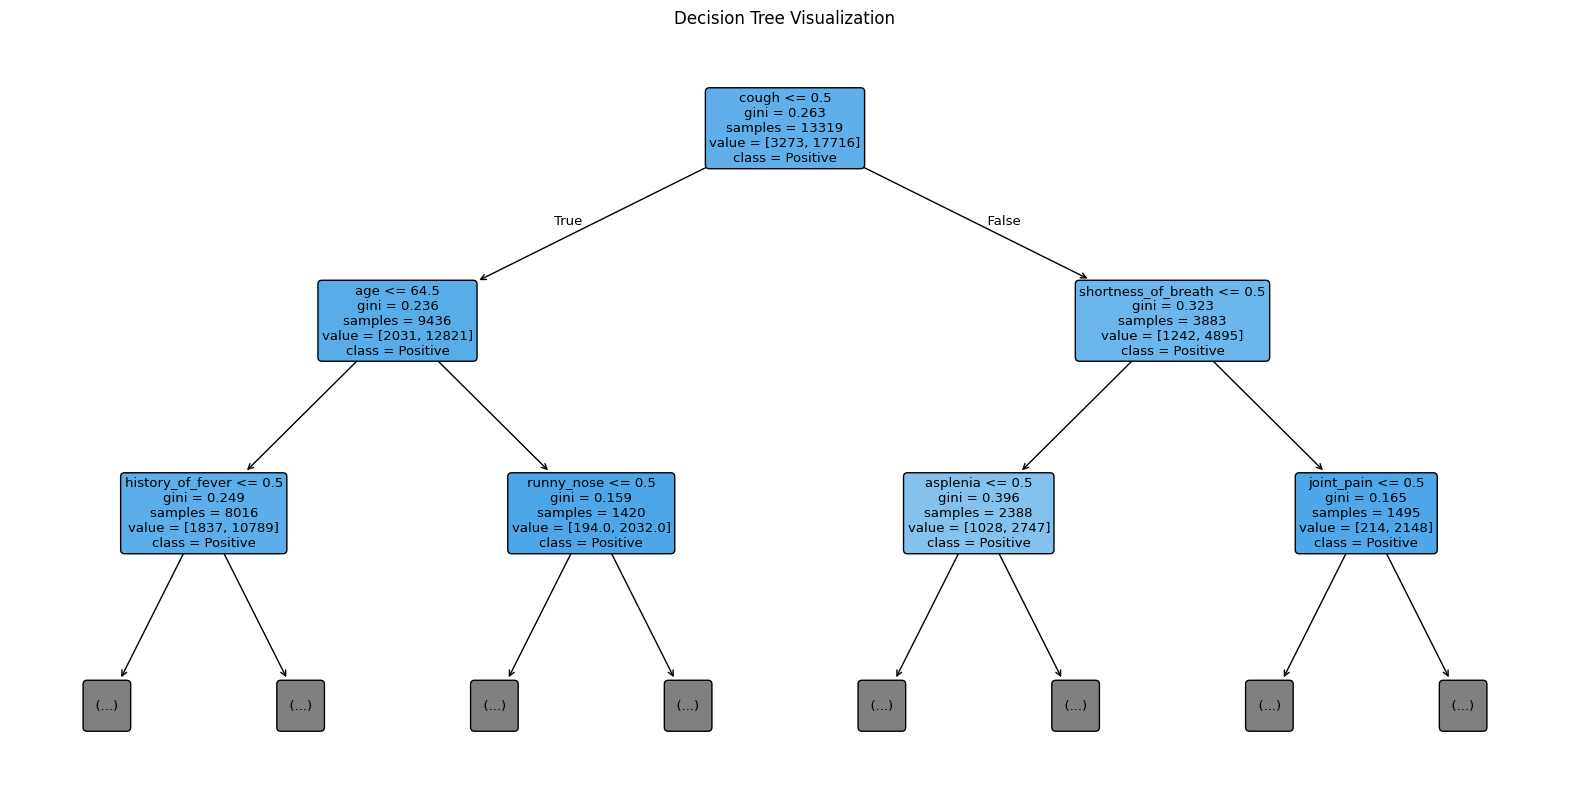

In [39]:
# Select the first 48 columns from X
X_selected = X.iloc[:, :48]  # Assuming X is the feature matrix

# Split the selected features into training and testing sets
X_train_sel, X_test_sel, Y_train_sel, Y_test_sel = train_test_split(X_selected, Y, test_size=0.2, random_state=42)

# Train a new Random Forest model on the selected features
model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
model_selected.fit(X_train_sel, Y_train_sel)

# Extract one tree from the Random Forest
single_tree_selected = model_selected.estimators_[0]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree_selected,
    feature_names=X_selected.columns,
    class_names=['Negative', 'Positive'],
    filled=True,
    rounded=True,
    max_depth=2  # Limit depth for readability
)
plt.title("Decision Tree Visualization")
plt.show()

In [40]:
# Extract one tree from Random Forest
single_tree_selected = model_selected.estimators_[0]

# Get textual representation of the tree
tree_rules = export_text(single_tree_selected, feature_names=list(X_selected.columns))
print(tree_rules)

|--- cough <= 0.50
|   |--- age <= 64.50
|   |   |--- history_of_fever <= 0.50
|   |   |   |--- chest_pain <= 0.50
|   |   |   |   |--- muscle_aches <= 0.50
|   |   |   |   |   |--- loss_of_smell <= 0.50
|   |   |   |   |   |   |--- diarrhoea <= 0.50
|   |   |   |   |   |   |   |--- lower_chest_wall_indrawing <= 0.50
|   |   |   |   |   |   |   |   |--- bleeding <= 0.50
|   |   |   |   |   |   |   |   |   |--- fatigue_malaise <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- sore_throat <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 41
|   |   |   |   |   |   |   |   |   |   |--- sore_throat >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |--- fatigue_malaise >  0.50
|   |   |   |   |   |   |   |   |   |   |--- diabetes_mellitus_type_2 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 19
|   |   |   |   |   |   |   |   |   |   |--- diabetes_m

### **Interpretation of the decision tree**

**Example:**

**Path Without Cough:** If a patient does not have a cough and is younger than 64.5 years old:

- If they also do not have a history of fever and chest pain, the model further evaluates muscle aches and other symptoms.
- Muscle aches with a low-grade fever temperature, however, not beyond 37.32°C, would lead to an absence of sore throat and classifying under class: 1.0 under certain conditions like altered consciousness or confusion.

**Path With Cough:** If a patient has a cough:

- The asplenia evaluation includes not only an assessment of shortness of breath and its severity, but also considers other risk factors such as obesity.
- The classification of the patient will depend on the aforementioned factors and other factors, for instance smoking behaviors or temperature of fever.

## 9. Conclusion

**Strengths of the model:**

* The model successfully detects true positive cases which details with the business objective of targeting high-risk patients in the first place.
* The precision and recall for positive PCR results are particularly strong, indicating that the model is reliable in identifying COVID-19 positive cases.
* Feature importance analysis helps to understand the significant predictors of COVID-19 positivity, e.g. causing fever and oxygen saturation levels, among others.


**Weaknesses of the model:**

* The previous issues related to missing PCR results have been resolved by removing those entries entirely, eliminating the need for placeholder values. This enhances the dataset's integrity.
* The intermediate performance for Class 0 (which contains negative PCR results) shows that there is further enhancement to be made in separation between positive and negative cases.

The data mining objective of the project was accomplished satisfactorily with a significant improvement in the predictive model for positive cases of COVID-19. However, there is a need for some improvements on the performance for negative and missing cases to ensure balanced predictions for all classes. Based on the consideration of feature importance and the decision tree rules, this model can be adopted in hospital settings to promote early detection during pandemics and strategic resource allocation of hospital wards.

### +1 HANDLING IMBALANCE - SMOTE for increasing the number of cases in the data in a balanced way (optional stuffs)

In [41]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

# Step 1: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, Y_train_balanced = smote.fit_resample(X_train, Y_train)

# Step 2: Drop Date Features (if needed)
X_train_balanced.drop(columns=['admission_year', 'symptom_year'], inplace=True)
X_test.drop(columns=['admission_year', 'symptom_year'], inplace=True)

# Step 3: Hyperparameter Tuning with Randomized Search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_dist,
                                   n_iter=10, cv=3, scoring='f1', random_state=42)
random_search.fit(X_train_balanced, Y_train_balanced)

# Step 4: Train Best Model
best_model = random_search.best_estimator_
best_model.fit(X_train_balanced, Y_train_balanced)

# Step 5: Evaluate Performance
y_pred_balanced = best_model.predict(X_test)
print(classification_report(Y_test, y_pred_balanced))

              precision    recall  f1-score   support

           0       0.61      0.64      0.63       815
           1       0.93      0.93      0.93      4433

    accuracy                           0.88      5248
   macro avg       0.77      0.78      0.78      5248
weighted avg       0.88      0.88      0.88      5248



### **Class breakdown - with SMOTE**
**Negative (0) PCR result:**
*   Precision -> 61% of predictions for 'negative' are correct. (while running in Colab it gave 62%)
*   Recall -> Only 64% of actual 'negative' cases are identified correctly.
* F1-score -> 0.63: Moderate performance for this class.

**Positive (1) PCR result:**
*   Precision -> 93% of predictions for 'positive' are correct.
*   Recall -> 93% of actual 'positive' cases are identified correctly.
* F1-score -> 0.93: Excellent performance for this class.

## **Overall metrics**

**Accuracy:** The model's ability to accurately predict 88% of the entire set of test samples, is satisfactory in general.

**Macro average:** When all classes are treated equally, irrespective of their prevalence, the figures for precision (0.77) and recall (0.78) indicate good performance, though there remains an opportunity to enhance recall for negative cases. (while running in Colab it gave 0.78 for precision)

**Weighted average:** The preservation of imbalance in the class distribution (for instance, a greater number of samples in Class 1) improves the results of Precision (0.88) and Recall (0.88).

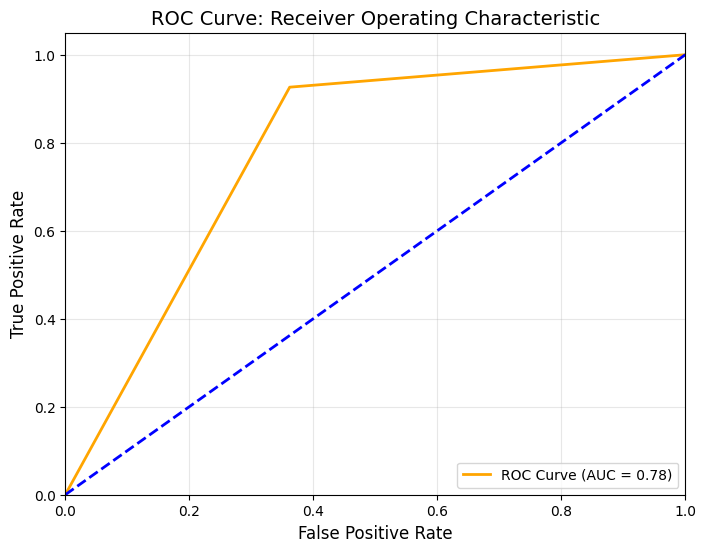

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
#ROC curve
# Assuming Y_test contains actual labels and y_pred_prob holds predicted probabilities for the positive class
false_positive_rate, true_positive_rate, threshold_values = roc_curve(Y_test, y_pred_balanced)
roc_auc_value = roc_auc_score(Y_test, y_pred_balanced)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, color='orange', linewidth=2,
         label=f'ROC Curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', linewidth=2)  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve: Receiver Operating Characteristic', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

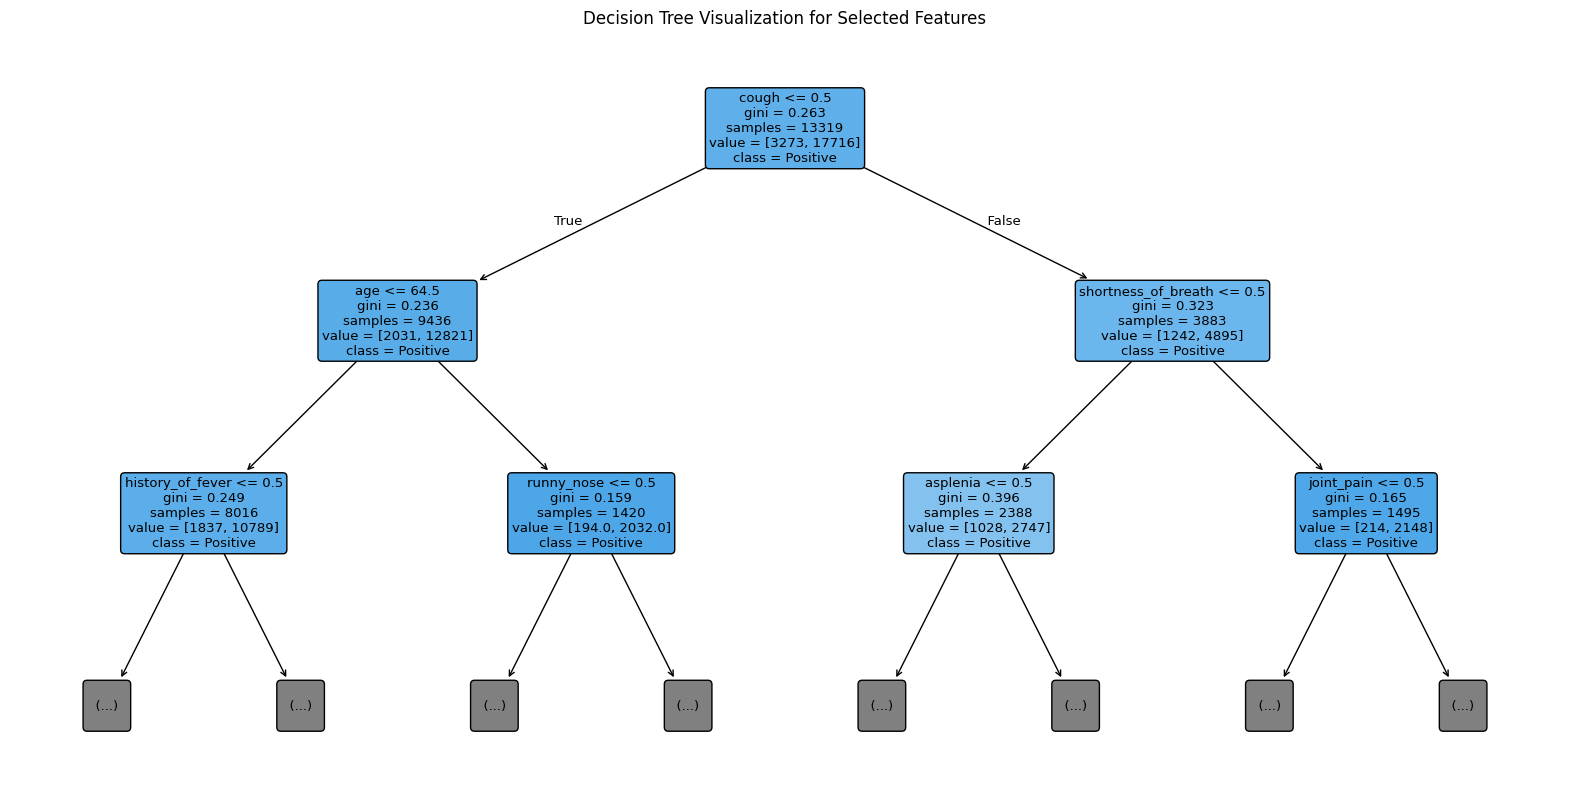

In [43]:
# Select the first 48 columns from X
X_selected = X.iloc[:, :48]  # Assuming X is the feature matrix

# Split the selected features into training and testing sets
X_train_sel, X_test_sel, Y_train_sel, Y_test_sel = train_test_split(X_selected, Y, test_size=0.2, random_state=42)

# Train a new Random Forest model on the selected features
model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
model_selected.fit(X_train_sel, Y_train_sel)

# Extract one tree from the Random Forest
single_tree_selected = model_selected.estimators_[0]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree_selected,
    feature_names=X_selected.columns,
    class_names=['Negative', 'Positive'],  # Adjust class names as needed
    filled=True,
    rounded=True,
    max_depth=2  # Limit depth for readability
)
plt.title("Decision Tree Visualization for Selected Features")
plt.show()

Author: Ádám Földvári